In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# ----------------------------------------------------
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# ----------------------------------------------------
from sklearn.metrics import auc, roc_curve, roc_auc_score
from collections import Counter

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Define Functions

In [2]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)
    
# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    
 
# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

In [3]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Explore Data

In [4]:
train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

The training data has 307511 observations (each one separate loan) and 122 features inclding the **Target** (the label we want to predict)

In [5]:
# Testing data features
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Examine the distribution of the target column
The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

Text(0.5, 1.0, 'Target feature distribution in data')

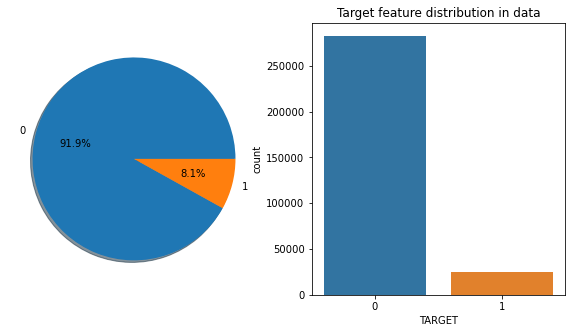

In [6]:
#Distribution of data in target feature

plt.figure(figsize=(10,5))

#plot pie chart
plt.subplot(1,2,1)
label = train.TARGET.value_counts().index
label_count = train.TARGET.value_counts().values
plt.pie(data=train, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1)

#
plt.subplot(1,2,2)
sns.countplot(x='TARGET', data=train)
plt.title('Target feature distribution in data')

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Feature Engineering

- Here we can create a new feature to find out the ratio of their income to the total loan and also the percentage of their credit with their income. This table can be useful to find out what percentage of the total loan and income ratio of those whose installment payments are more than the specified day (Target = 1).
- From this table we can also see whether the loan amount requested by the client exceeds their total income, causing the client to default > 30 days.

In [7]:
train_df = train.copy()

In [8]:
## create Credit/Income and Annuity/Income percentages
train_df['Credit/Income'] = train['AMT_CREDIT']/train_df['AMT_INCOME_TOTAL']
train_df['Annuity/Income'] = train_df['AMT_ANNUITY']/train_df['AMT_INCOME_TOTAL']

## show only clients with late payment
train_df[train_df['TARGET']==1].sort_values(by='Credit/Income', ascending=True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Credit/Income,Annuity/Income
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,...,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.004808,0.000224
197551,329042,1,Cash loans,F,Y,Y,0,405000.0,76410.0,9067.5,...,0,0,0.0,0.0,0.0,2.0,0.0,3.0,0.188667,0.022389
106358,223392,1,Cash loans,M,Y,Y,1,540000.0,106974.0,8451.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.198100,0.015650
91487,206240,1,Cash loans,M,N,Y,1,225000.0,45000.0,5467.5,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.024300
156330,281213,1,Cash loans,M,N,Y,2,405000.0,83403.0,10026.0,...,0,0,0.0,0.0,0.0,1.0,0.0,4.0,0.205933,0.024756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205575,338291,1,Cash loans,F,N,N,0,36000.0,1223010.0,48627.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,33.972500,1.350750
678,100784,1,Cash loans,F,N,Y,0,54000.0,1885500.0,74191.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,34.916667,1.373917
255247,395348,1,Cash loans,F,N,Y,1,58500.0,2146500.0,51340.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,36.692308,0.877615
226137,361920,1,Cash loans,F,N,Y,0,45000.0,1800000.0,62698.5,...,0,0,0.0,0.0,0.0,0.0,0.0,3.0,40.000000,1.393300


## Business Insight From Data

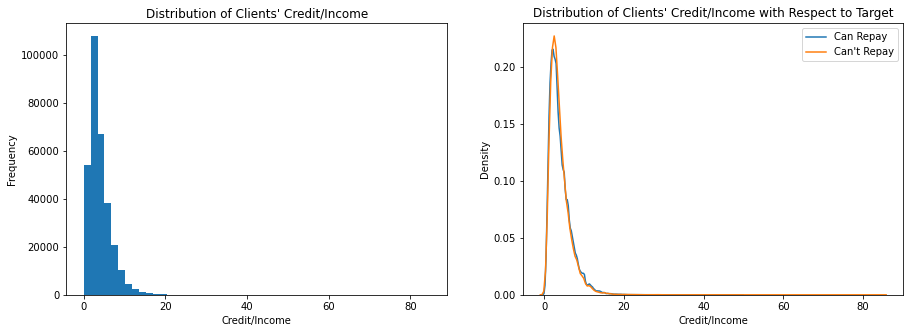

In [9]:
# Is there relation between the age and the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
train_df['Credit/Income'].plot(kind='hist', bins=50, title='Distribution of Clients\' Credit/Income');
plt.xlabel('Credit/Income')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
proper_credit_df = train_df[['Credit/Income', 'TARGET']]
proper_credit_df['Credit/Income'] = proper_credit_df['Credit/Income']
sns.distplot(proper_credit_df[proper_credit_df['TARGET']==0]['Credit/Income'], hist=False, label='Can Repay');
sns.distplot(proper_credit_df[proper_credit_df['TARGET']==1]['Credit/Income'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' Credit/Income with Respect to Target')
plt.xlabel('Credit/Income')
plt.legend();
plt.show()

- Clients Credit/Income about 5-10 are more likely to have difficulties with repay.
- This feature will be important for the model.

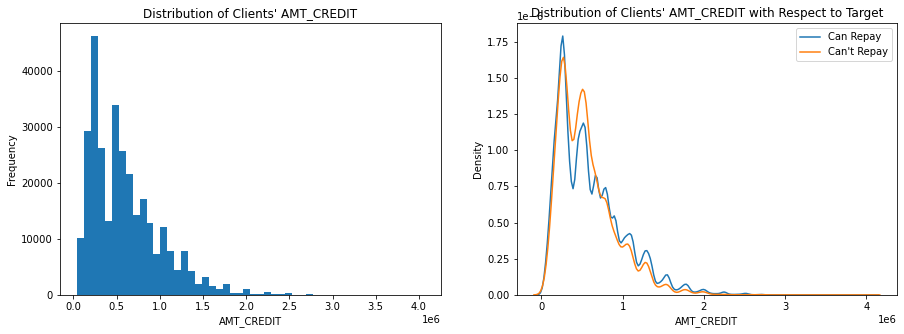

In [10]:
# Is there relation between the age and the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
train['AMT_CREDIT'].plot(kind='hist', bins=50, title='Distribution of Clients\' AMT_CREDIT');
plt.xlabel('AMT_CREDIT')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
proper_credit_df = train[['AMT_CREDIT', 'TARGET']]
proper_credit_df['AMT_CREDIT'] = proper_credit_df['AMT_CREDIT']
sns.distplot(proper_credit_df[proper_credit_df['TARGET']==0]['AMT_CREDIT'], hist=False, label='Can Repay');
sns.distplot(proper_credit_df[proper_credit_df['TARGET']==1]['AMT_CREDIT'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' AMT_CREDIT with Respect to Target')
plt.xlabel('AMT_CREDIT')
plt.legend();
plt.show()

- Clients amount credit under 1 are more likely to have difficulties with repay, where those aged more than 1 can repay well.
- This feature will be important for the model.

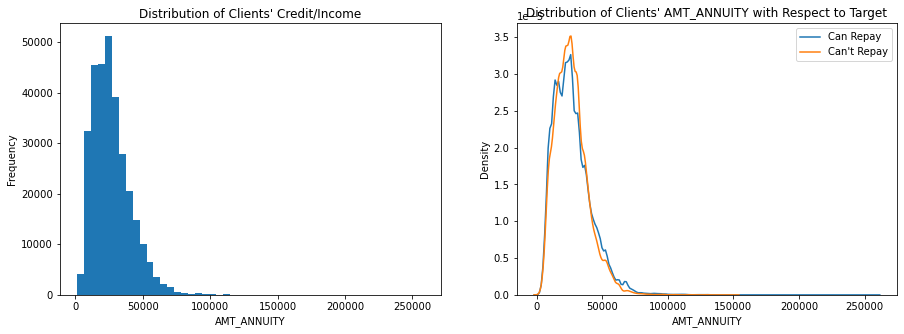

In [11]:
# Is there relation between the age and the ability to repay?

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
train['AMT_ANNUITY'].plot(kind='hist', bins=50, title='Distribution of Clients\' Credit/Income');
plt.xlabel('AMT_ANNUITY')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
proper_credit_df = train[['AMT_ANNUITY', 'TARGET']]
proper_credit_df['AMT_ANNUITY'] = proper_credit_df['AMT_ANNUITY']
sns.distplot(proper_credit_df[proper_credit_df['TARGET']==0]['AMT_ANNUITY'], hist=False, label='Can Repay');
sns.distplot(proper_credit_df[proper_credit_df['TARGET']==1]['AMT_ANNUITY'], hist=False, label='Can\'t Repay');
plt.title('Distribution of Clients\' AMT_ANNUITY with Respect to Target')
plt.xlabel('AMT_ANNUITY')
plt.legend();
plt.show()

- Clients amount annuity about 30000-40000 are more likely to have difficulties with repay, where those amount annuity over 50000 can repay well.
- This feature will be important for the model.

## Preprocessing

### Manage Missing Data in Numerical Field

In [12]:
threshold_train = len(train) * 0.60
int(threshold_train)

184506

In [13]:
threshold_test = len(test) * 0.60
int(threshold_test)

29246

In [14]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI',
       'FONDKAPREMONT_MODE'],
      dtype='object')


In [15]:
train_new = train.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(307511, 73)
******************************************
(48744, 72)


In [16]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [17]:
numeric = train_new[final_numeric_feature]

numeric_test = test_new[final_numeric_feature_test]
numeric.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
discrete_features = numeric.dtypes==int
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

discrete_features_test = numeric_test.dtypes==int
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

In [19]:
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0


In [20]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0


In [21]:
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_features_test = numeric_test.dtypes==float
final_continuous_feature_test = numeric_test.columns[continuous_features_test].tolist()
continuous_test = numeric_test[final_continuous_feature_test]

continuous.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,202500.0,406597.5,24700.5,351000.0,0.018801,-3648.0,1.0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0.0,0.0,0.0,0.0,0.0,1.0
1,270000.0,1293502.5,35698.5,1129500.0,0.003541,-1186.0,2.0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67500.0,135000.0,6750.0,135000.0,0.010032,-4260.0,1.0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0.0,0.0,0.0,0.0,0.0,0.0
3,135000.0,312682.5,29686.5,297000.0,0.008019,-9833.0,2.0,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,NaN,NaN,NaN,NaN,NaN,NaN
4,121500.0,513000.0,21865.5,513000.0,0.028663,-4311.0,1.0,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,60965
AMT_REQ_CREDIT_BUREAU_YEAR,41519
AMT_REQ_CREDIT_BUREAU_QRT,41519
AMT_REQ_CREDIT_BUREAU_MON,41519
AMT_REQ_CREDIT_BUREAU_WEEK,41519
AMT_REQ_CREDIT_BUREAU_DAY,41519
AMT_REQ_CREDIT_BUREAU_HOUR,41519
OBS_60_CNT_SOCIAL_CIRCLE,1021
DEF_60_CNT_SOCIAL_CIRCLE,1021
DEF_30_CNT_SOCIAL_CIRCLE,1021


In [23]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
EXT_SOURCE_3,8668
AMT_REQ_CREDIT_BUREAU_YEAR,6049
AMT_REQ_CREDIT_BUREAU_QRT,6049
AMT_REQ_CREDIT_BUREAU_MON,6049
AMT_REQ_CREDIT_BUREAU_WEEK,6049
AMT_REQ_CREDIT_BUREAU_DAY,6049
AMT_REQ_CREDIT_BUREAU_HOUR,6049
OBS_60_CNT_SOCIAL_CIRCLE,29
DEF_60_CNT_SOCIAL_CIRCLE,29
DEF_30_CNT_SOCIAL_CIRCLE,29


In [24]:
continuous_col = continuous.columns

In [25]:
Q1 = train_new.quantile(0.25)
Q3 = train_new.quantile(0.75)
IQR = Q3 - Q1

*********************** AMT_INCOME_TOTAL ***********************

lower outlier: 0 ****** upper outlier: 14035



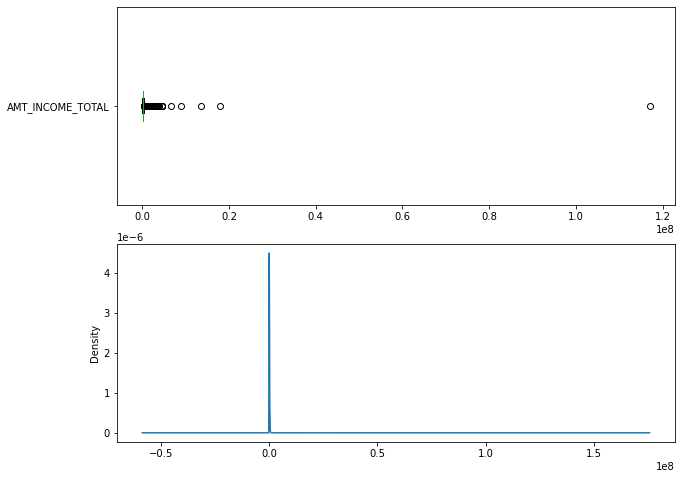

*********************** AMT_CREDIT ***********************

lower outlier: 0 ****** upper outlier: 6562



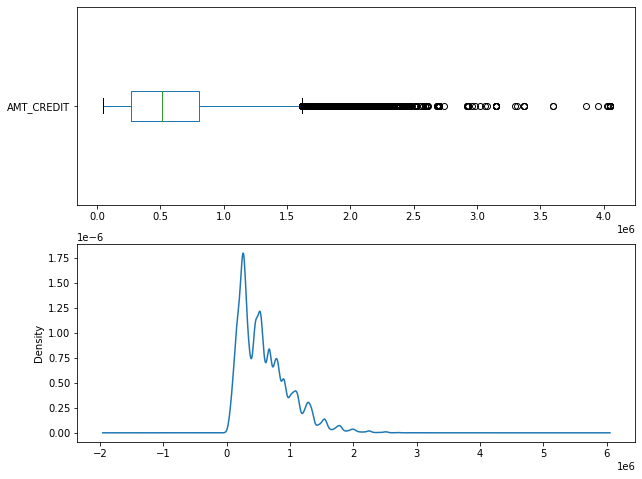

*********************** AMT_ANNUITY ***********************

lower outlier: 0 ****** upper outlier: 7504



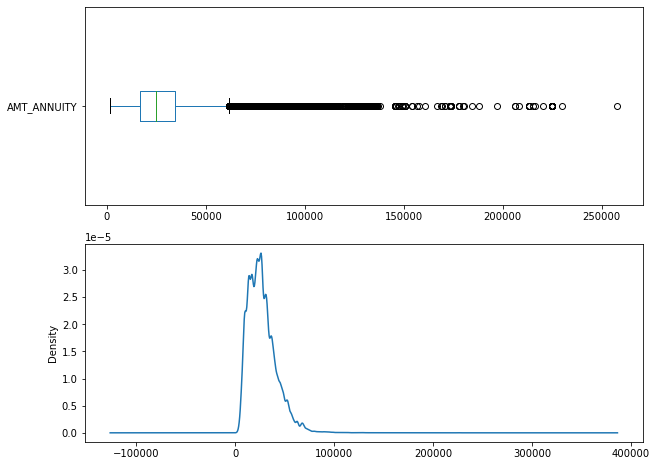

*********************** AMT_GOODS_PRICE ***********************

lower outlier: 0 ****** upper outlier: 14728



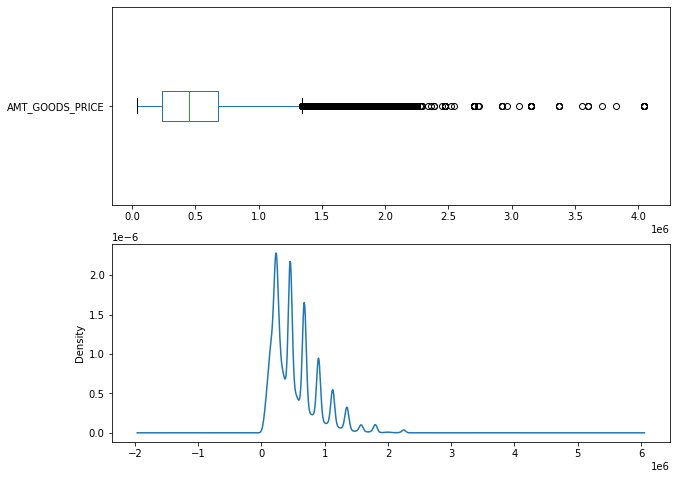

*********************** REGION_POPULATION_RELATIVE ***********************

lower outlier: 0 ****** upper outlier: 8412



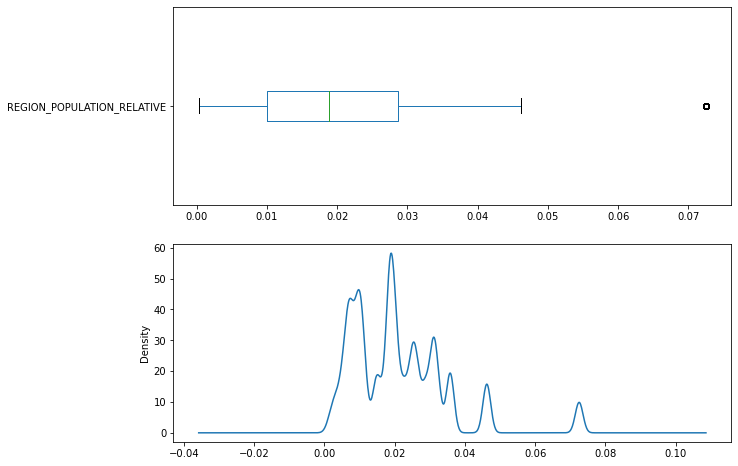

*********************** DAYS_REGISTRATION ***********************

lower outlier: 659 ****** upper outlier: 0



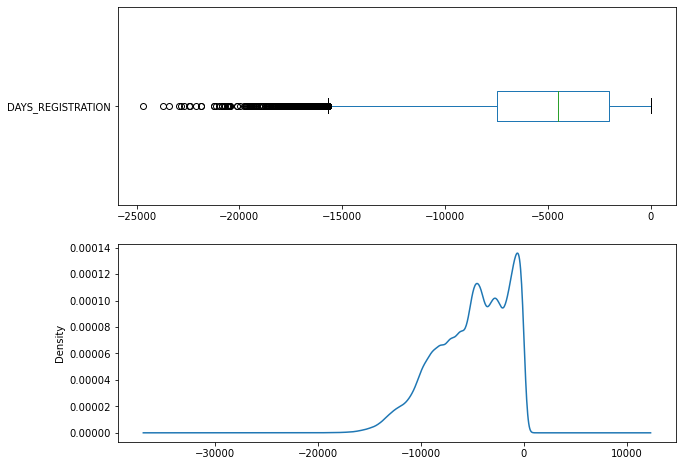

*********************** CNT_FAM_MEMBERS ***********************

lower outlier: 0 ****** upper outlier: 4007



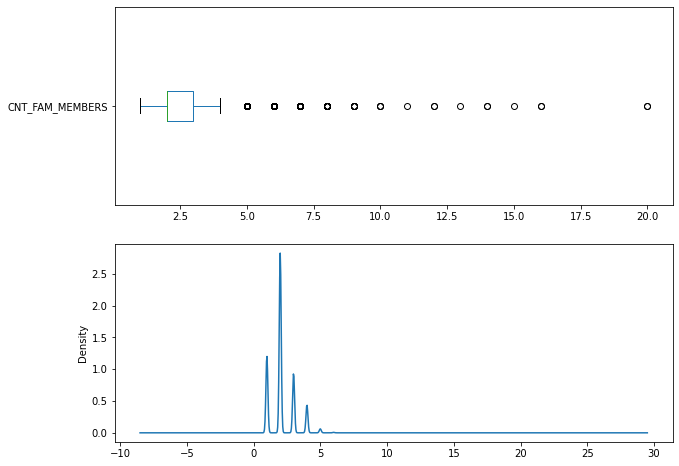

*********************** EXT_SOURCE_2 ***********************

lower outlier: 0 ****** upper outlier: 0



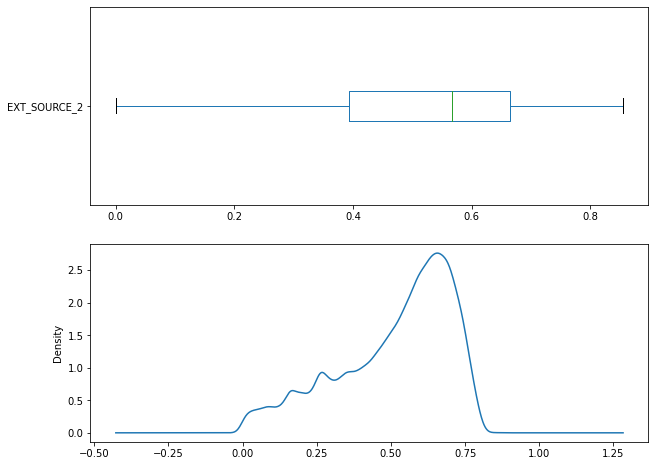

*********************** EXT_SOURCE_3 ***********************

lower outlier: 0 ****** upper outlier: 0



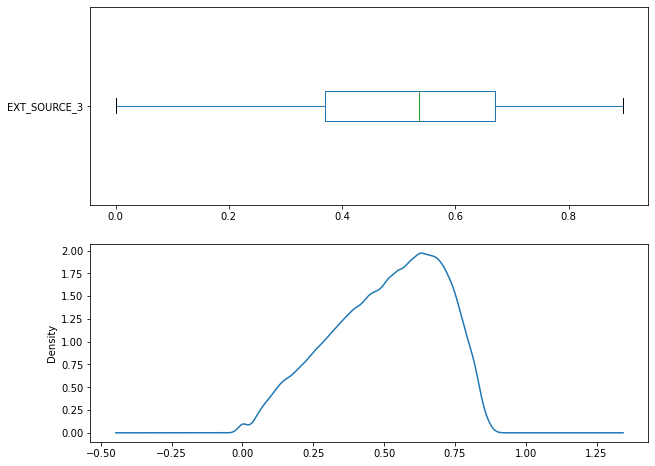

*********************** OBS_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19971



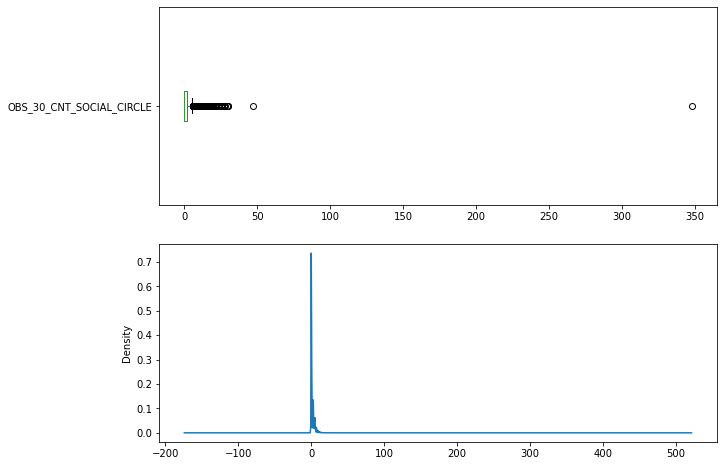

*********************** DEF_30_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 35166



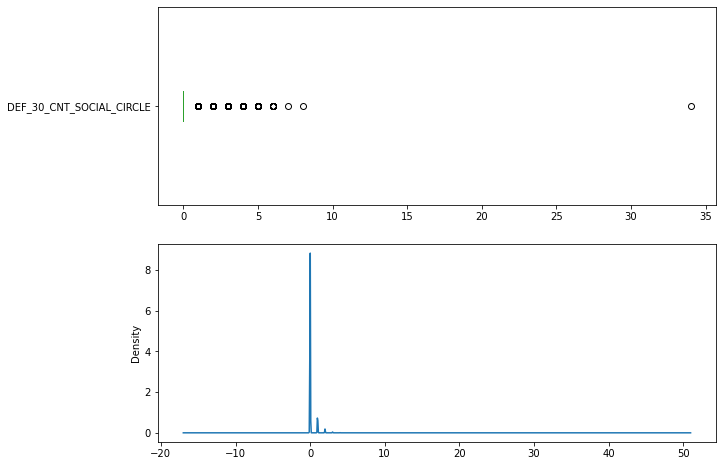

*********************** OBS_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 19564



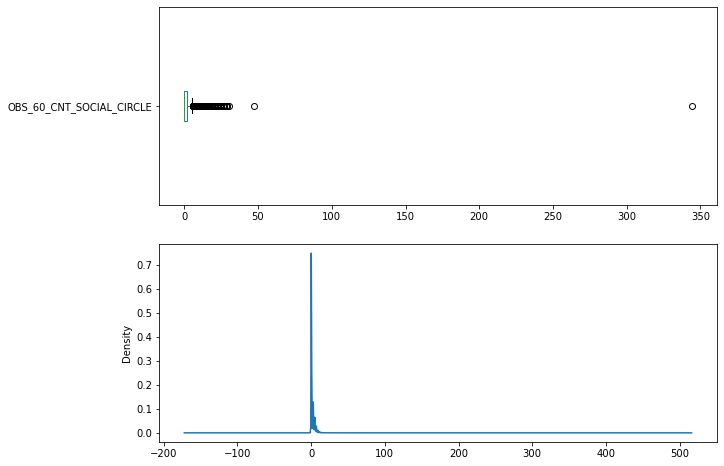

*********************** DEF_60_CNT_SOCIAL_CIRCLE ***********************

lower outlier: 0 ****** upper outlier: 25769



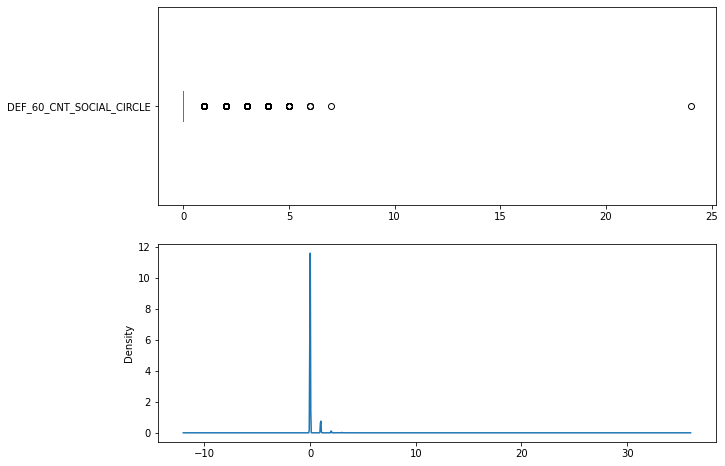

*********************** DAYS_LAST_PHONE_CHANGE ***********************

lower outlier: 435 ****** upper outlier: 0



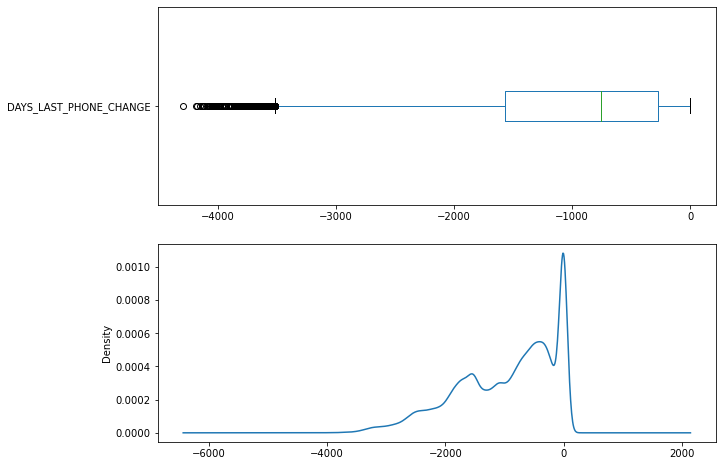

*********************** AMT_REQ_CREDIT_BUREAU_HOUR ***********************

lower outlier: 0 ****** upper outlier: 1626



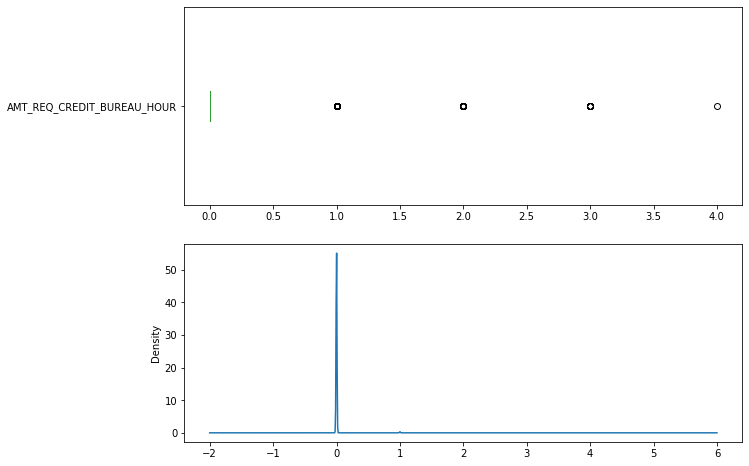

*********************** AMT_REQ_CREDIT_BUREAU_DAY ***********************

lower outlier: 0 ****** upper outlier: 1489



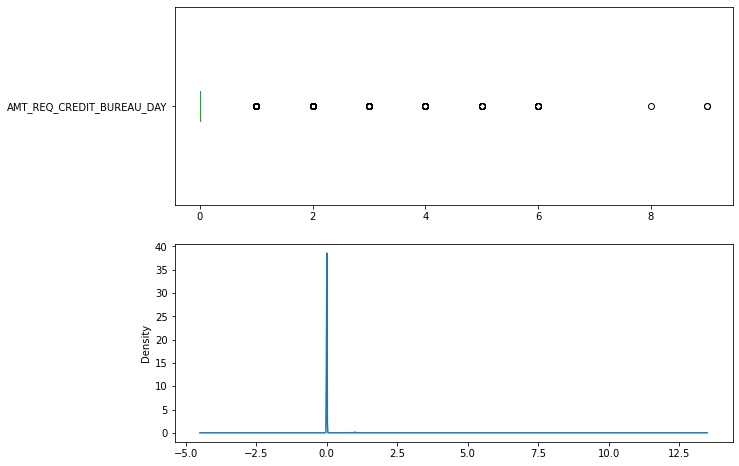

*********************** AMT_REQ_CREDIT_BUREAU_WEEK ***********************

lower outlier: 0 ****** upper outlier: 8536



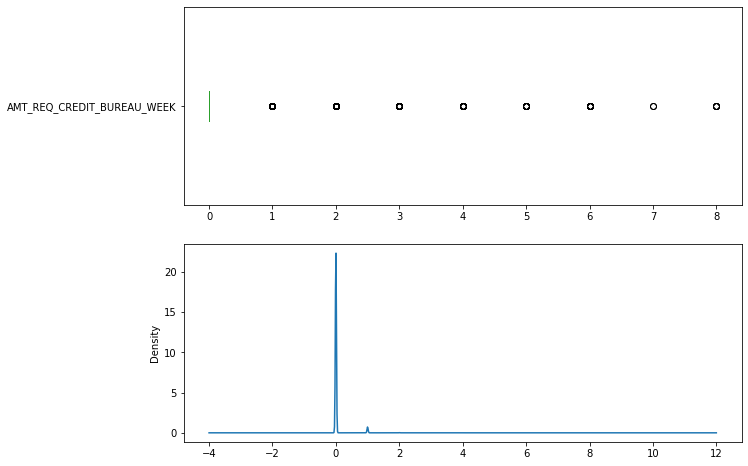

*********************** AMT_REQ_CREDIT_BUREAU_MON ***********************

lower outlier: 0 ****** upper outlier: 43759



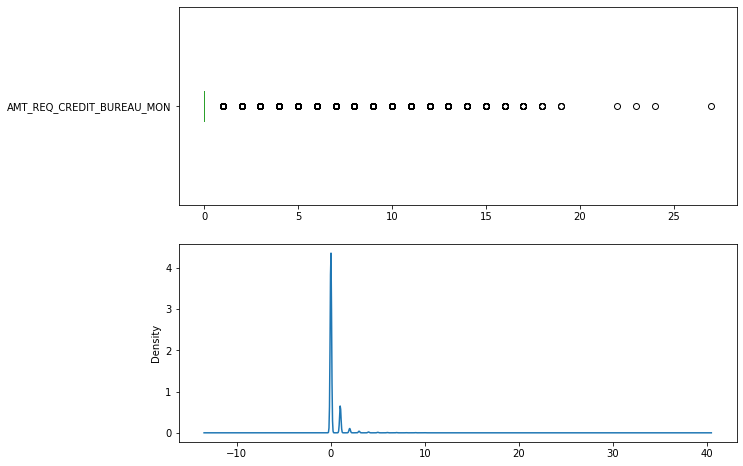

*********************** AMT_REQ_CREDIT_BUREAU_QRT ***********************

lower outlier: 0 ****** upper outlier: 50575



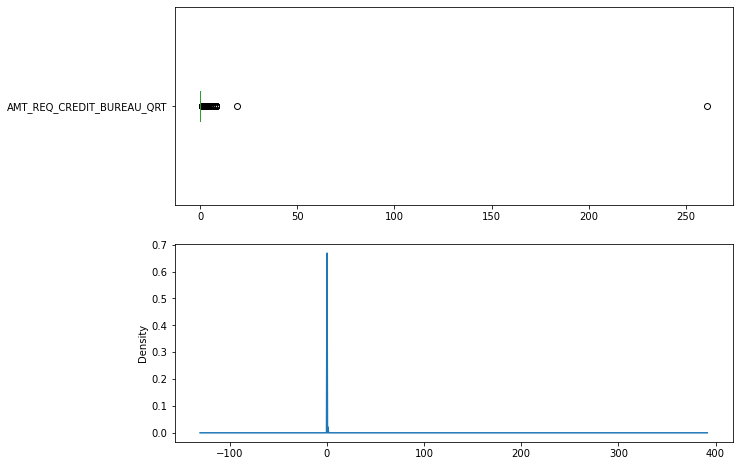

*********************** AMT_REQ_CREDIT_BUREAU_YEAR ***********************

lower outlier: 0 ****** upper outlier: 3364



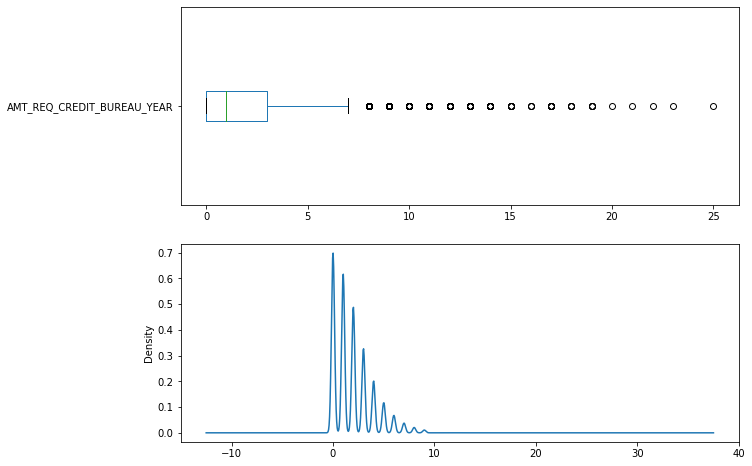

In [26]:
for i in range(len(continuous_col)):
    preprocess(continuous[continuous_col], continuous_col[i])

From the boxplot results, it can be seen that there are few outliers in dataset

In [27]:
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
****************************************
In test: 
 ['AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']


In [28]:
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27108.573909183444
NaN in AMT_GOODS_PRICE raplaced with 538396.2074288887
NaN in CNT_FAM_MEMBERS raplaced with 2.1526654504421012
NaN in EXT_SOURCE_2 raplaced with 0.5143926741308488
NaN in EXT_SOURCE_3 raplaced with 0.5108529061805426
NaN in OBS_30_CNT_SOCIAL_CIRCLE raplaced with 1.4222454239942892
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.1434206662533827
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4052921791902133
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10004894123788487
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -962.8587883320869
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.0064024481939340665
NaN in AMT_REQ_CREDIT_BUREAU_DAY raplaced with 0.007000210532644792
NaN in AMT_REQ_CREDIT_BUREAU_WEEK raplaced with 0.03436193569730462
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26739526000773584
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.2654741495984415
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.8999744

In [29]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [30]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
AMT_INCOME_TOTAL,0
AMT_CREDIT,0
AMT_REQ_CREDIT_BUREAU_QRT,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
DAYS_LAST_PHONE_CHANGE,0
DEF_60_CNT_SOCIAL_CIRCLE,0
OBS_60_CNT_SOCIAL_CIRCLE,0


In [31]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

### Manage Outlier

In [32]:
col_names = numeric.columns

# ------------------------------------
col_names_test = numeric_test.columns

In [33]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(numeric,col_names[i]).shape[0])))
    
print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))

In train:

SK_ID_CURR: 0
TARGET: 24825
CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_BIRTH: 0
DAYS_EMPLOYED: 72217
DAYS_REGISTRATION: 659
DAYS_ID_PUBLISH: 0
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 574
FLAG_PHONE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 80527
REGION_RATING_CLIENT_W_CITY: 78027
HOUR_APPR_PROCESS_START: 2257
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 36187
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 26790
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_2: 13
FLAG_DOCUMENT_3: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 

In [34]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(numeric[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])

In [35]:
# without TARGET field
col_names = outlier_test

In [36]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 4272
AMT_INCOME_TOTAL: 14035
AMT_CREDIT: 6562
AMT_ANNUITY: 7504
AMT_GOODS_PRICE: 14728
REGION_POPULATION_RELATIVE: 8412
DAYS_EMPLOYED: 55374
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 61308
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 17442
CNT_FAM_MEMBERS: 4007
REGION_RATING_CLIENT: 48330
REGION_RATING_CLIENT_W_CITY: 43860
HOUR_APPR_PROCESS_START: 596
REG_REGION_NOT_LIVE_REGION: 4657
REG_REGION_NOT_WORK_REGION: 15612
LIVE_REGION_NOT_WORK_REGION: 12503
REG_CITY_NOT_LIVE_CITY: 24039
REG_CITY_NOT_WORK_CITY: 70867
LIVE_CITY_NOT_WORK_CITY: 55215
OBS_30_CNT_SOCIAL_CIRCLE: 19971
DEF_30_CNT_SOCIAL_CIRCLE: 36187
OBS_60_CNT_SOCIAL_CIRCLE: 19564
DEF_60_CNT_SOCIAL_CIRCLE: 26790
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 25
FLAG_DOCUMENT_5: 4648
FLAG_DOCUMENT_6: 27078
FLAG_DOCUMENT_7: 59
FLAG_DOCUMENT_8: 25024
FLAG_DOCUMENT_9: 1198
FLAG_DOCUMENT_11: 1203
FLAG_DOCUMENT_18: 2500
AMT_REQ_CREDIT_BUREAU_HOUR: 43145
AMT_REQ_CREDIT_BUREAU_DAY: 43008
AMT_REQ_CREDIT_B

In [37]:
for i in range(len(col_names)):
    replace_upper(numeric, col_names[i])   
    
#------------------------------------------------------
for i in range(len(col_names)):
    replace_upper(numeric_test, col_names[i]) 

In [38]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


**********

In [39]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 16843
DAYS_REGISTRATION: 659
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 55386
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 574
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 32197
REGION_RATING_CLIENT_W_CITY: 34167
HOUR_APPR_PROCESS_START: 1661
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 435
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BU

In [40]:
for i in range(len(col_names)):
    replace_lower(numeric, col_names[i])
    
# #--------------------------------------------------
for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])

In [41]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
FLAG_MOBIL: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
HOUR_APPR_PROCESS_START: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
OBS_30_CNT_SOCIAL_CIRCLE: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
FLAG_DOCUMENT_4: 0
FLAG_DOCUMENT_5: 0
FLAG_DOCUMENT_6: 0
FLAG_DOCUMENT_7: 0
FLAG_DOCUMENT_8: 0
FLAG_DOCUMENT_9: 0
FLAG_DOCUMENT_11: 0
FLAG_DOCUMENT_18: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_DAY: 0
AMT_REQ_CREDIT_BUREAU_WEEK: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0


**********

### Manage Missing Data in Categorical Field

In [42]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [43]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion


In [44]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,96391
NAME_TYPE_SUITE,1292
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [45]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,15605
NAME_TYPE_SUITE,911
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


In [46]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



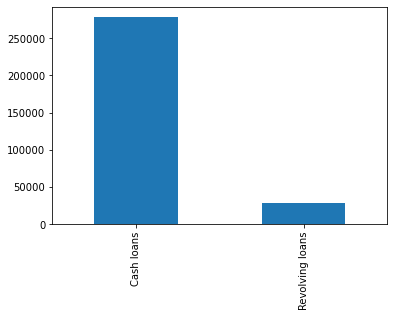

******************** CODE_GENDER ********************



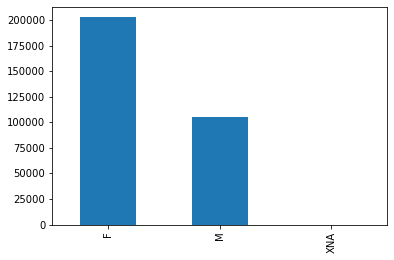

******************** FLAG_OWN_CAR ********************



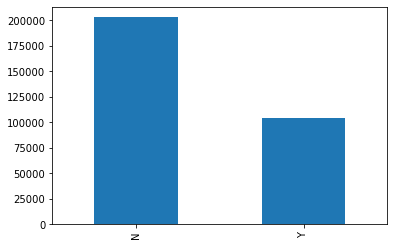

******************** FLAG_OWN_REALTY ********************



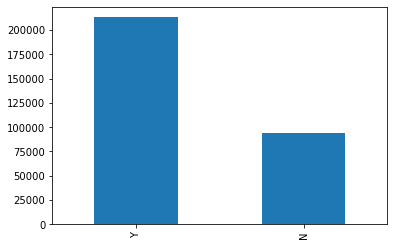

******************** NAME_TYPE_SUITE ********************



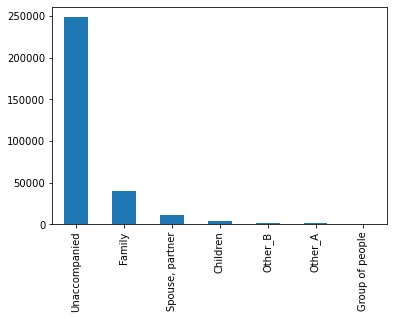

******************** NAME_INCOME_TYPE ********************



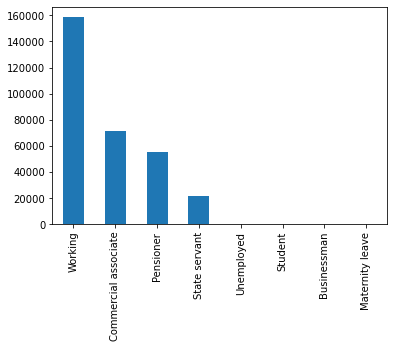

******************** NAME_EDUCATION_TYPE ********************



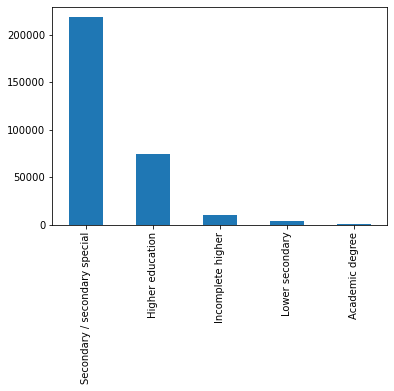

******************** NAME_FAMILY_STATUS ********************



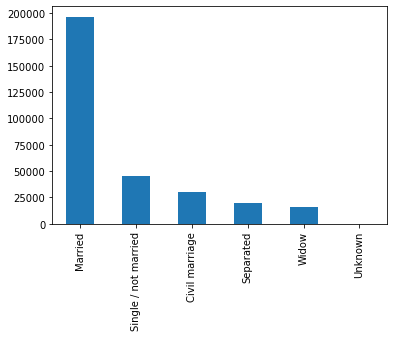

******************** NAME_HOUSING_TYPE ********************



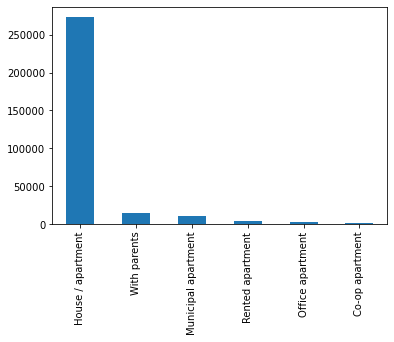

******************** OCCUPATION_TYPE ********************



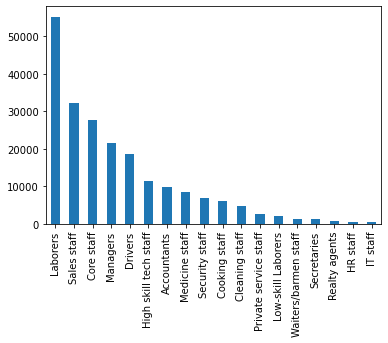

******************** WEEKDAY_APPR_PROCESS_START ********************



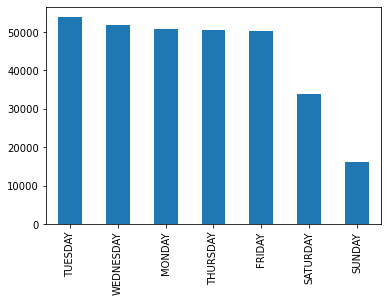

******************** ORGANIZATION_TYPE ********************



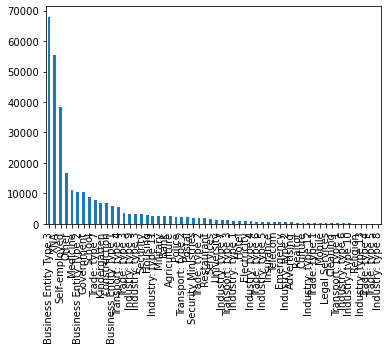

In [47]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [48]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6'] 


In [49]:
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in WEEKDAY_APPR_PROCESS_START raplaced with TUESDAY
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_EDUCATION_TYPE raplaced with Secondary / secondary special
NaN in N

In [50]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [51]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [52]:
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [53]:
le = LabelEncoder() 
categorical = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START
0,0,1,0,1,6,7,4,3,1,8,6
1,0,0,0,0,1,4,1,1,1,3,1
2,1,1,1,1,6,7,4,3,1,8,1
3,0,0,0,1,6,7,4,0,1,8,6
4,0,1,0,1,6,7,4,3,1,3,4


In [54]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (307511, 11)
In test:  (48744, 11)


In [55]:
col_names_cat = categorical.columns
col_names = numeric_test.columns

In [56]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [57]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

### Manage Duplicate Data

In [58]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 72)
In test:  (0, 71)


## Normalization

In [59]:
x_train = train_new.drop("TARGET", axis = 1)
y = train_new['TARGET']

In [60]:
scaler=MinMaxScaler()
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [61]:
x_train[col] = pd.DataFrame(scaler.fit_transform(x_train[col]))
test_new[col] = pd.DataFrame(scaler.transform(test_new[col]))

### Modeling with tuned hyperparameters

We used Random search for tuning hyperparameters

### LGBM Classifier

In [62]:
lgb = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.2, 
                        'num_leaves': 70, 
                        'n_estimators': 250, 
                        'min_child_samples': 800, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

lgb.fit(x_train, y)
y_predict = lgb.predict(test_new)
scores_lgb = cross_validation(x_train, y, lgb)
print(scores_lgb)

Score: 0.750283
None


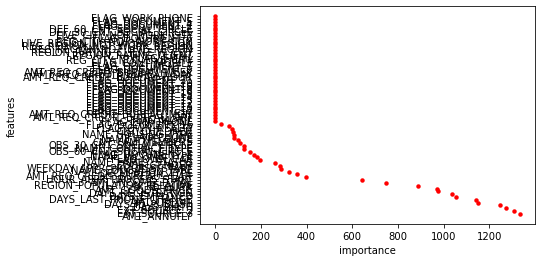

In [84]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance', 
    ylabel='features')
    
plot_importance(lgb, x_train,20)

### XGB Classifier

In [65]:
counter = Counter(y)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.387


In [66]:
xgbc = XGBClassifier(learning_rate=0.2, 
                     max_depth=4, 
                     n_jobs=-1, 
                     random_state=100,
                     scale_pos_weight=11.387150050352467)

xgbc.fit(x_train, y)
y_predict = xgbc.predict(test_new)
scores_xgbc = cross_validation(x_train, y, xgbc)
print(scores_xgbc)

Score: 0.749189
None


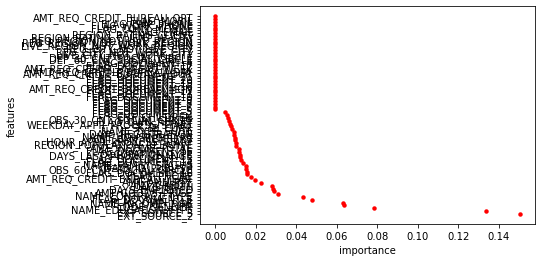

In [72]:
plot_importance(xgbc, x_train, 20)  

### AdaBoost Classifier

In [69]:
ada = AdaBoostClassifier(learning_rate=0.2, 
                         algorithm = 'SAMME.R',
                         n_estimators=200, 
                         random_state=100)
ada.fit(x_train, y)
y_predict = ada.predict(test_new)
scores_ada = cross_validation(x_train, y, ada)
print(scores_ada)

Score: 0.743294
None


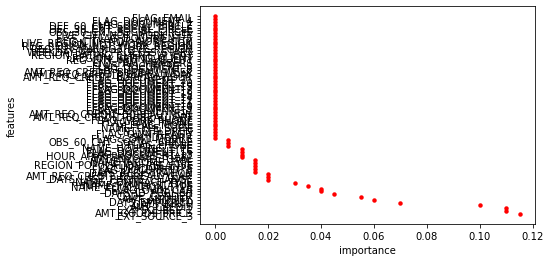

In [85]:
plot_importance(ada, x_train, 20)  

# Evaluation & Submission

In [88]:
classifiers = [lgb, xgbc, ada]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(x_train, y)
    yproba = model.predict_proba(x_train)[::,1]
    
    fpr, tpr, _ = roc_curve(y,  yproba)
    auc = roc_auc_score(y, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

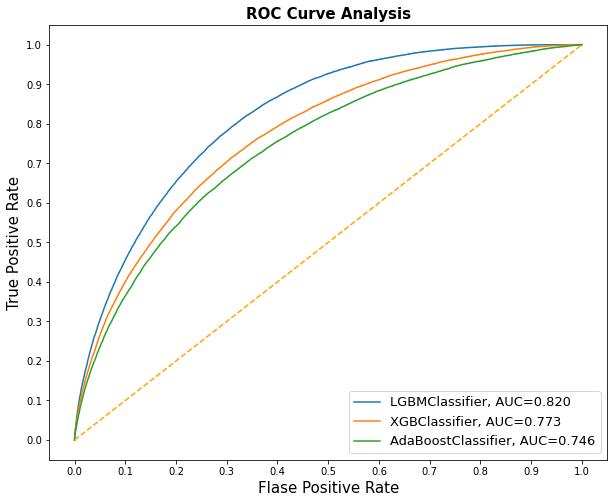

In [89]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc'])
             )
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

The best model is LGBMClassifier with AUC 0.82

In [90]:
lgb.fit(x_train, y)
y_pred_LGB = lgb.predict(x_train)
y_pred_LGB_test = lgb.predict(test_new)

In [91]:
output = pd.DataFrame({'SK_ID_CURR': test_new.SK_ID_CURR, 
                       'TARGET': lgb.predict_proba(test_new)[:,1]})
output.head()

,SK_ID_CURR,TARGET
0,100001,0.331551
1,100005,0.574056
2,100013,0.191457
3,100028,0.251431
4,100038,0.546200


# Light Gradient Boosting Machine

We can step off the deep end and use a real machine learning model: the gradient boosting machine using the LightGBM library! The Gradient Boosting Machine is currently the leading model for learning on structured datasets (especially on Kaggle) and we will probably need some form of this model to do well in this project. In the next step, we will see how to work with more advanced models (which mostly means adapting existing code to make it work better), feature engineering, and feature selection.